In [1]:
import findspark
findspark.init()

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession.builder.getOrCreate()

In [2]:
print(spark.version)

2.4.4


In [3]:
print(sc.version)

2.4.4


In [4]:
print(spark.catalog.listTables())

[]


In [5]:
import pandas as pd
pd_df_train = pd.read_excel('Data_Train.xlsx')
pd_df_test = pd.read_excel('Data_Test.xlsx')

pd_df_train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


Convert the data to a Spark DataFrame using the .createDataFrame() method

In [7]:
print(sc)

<SparkContext master=local[*] appName=pyspark-shell>


In [8]:
spark_df_train = spark.createDataFrame(pd_df_train)
spark_df_test = spark.createDataFrame(pd_df_test)

spark_df_train.show(10)

+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+------+
|               Title|              Author|             Edition|           Reviews|             Ratings|            Synopsis|               Genre|        BookCategory| Price|
+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+------+
|The Prisoner's Go...|      Chris Kuzneski|Paperback,– 10 Ma...|4.0 out of 5 stars|  8 customer reviews|THE HUNTERS retur...|Action & Adventur...|  Action & Adventure| 220.0|
|Guru Dutt: A Trag...|        Arun Khopkar|Paperback,– 7 Nov...|3.9 out of 5 stars| 14 customer reviews|A layered portrai...|Cinema & Broadcas...|Biographies, Diar...|202.93|
|Leviathan (Pengui...|       Thomas Hobbes|Paperback,– 25 Fe...|4.8 out of 5 stars|  6 customer reviews|"During the time ...|

In [9]:
print(spark.catalog.listTables())

[]


Still nothing in the table list why? no table has been added yet

I'll add one now

In [10]:
# Add spark_df_train to the catalog
spark_df_train.createOrReplaceTempView("temp")

In [11]:
print(spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


One question is why going through pandas when ultimately what yiu want is spark

Well ask no more Spark has a .read attribute which has several methods of reading diffrent sources of data into a spark Dataframe

Now Trying the .read

In [14]:
train_data = spark.read.csv('Data_Train.xlsx', header=True)

Since the data is in excel and spark has no option for excel, converting to a csv will be the best best

In [16]:
spark_df_train.show(5)

+--------------------+---------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+------+
|               Title|         Author|             Edition|           Reviews|            Ratings|            Synopsis|               Genre|        BookCategory| Price|
+--------------------+---------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+------+
|The Prisoner's Go...| Chris Kuzneski|Paperback,– 10 Ma...|4.0 out of 5 stars| 8 customer reviews|THE HUNTERS retur...|Action & Adventur...|  Action & Adventure| 220.0|
|Guru Dutt: A Trag...|   Arun Khopkar|Paperback,– 7 Nov...|3.9 out of 5 stars|14 customer reviews|A layered portrai...|Cinema & Broadcas...|Biographies, Diar...|202.93|
|Leviathan (Pengui...|  Thomas Hobbes|Paperback,– 25 Fe...|4.8 out of 5 stars| 6 customer reviews|"During the time ...|International Rel...|              H

Creating columns

 In Spark you can do this using the .withColumn() method, which takes two arguments. First, a string with the name of your new column, and second the new column itself. Quite different from pandas NO?

I'll be creating a new column from Reviews. I'll extract the actual review score from the column review

In [24]:
import pyspark.sql.functions as F
spark_df_train = spark_df_train.withColumn("ReviewScore", F.col('Reviews').str.split()[0])

TypeError: 'Column' object is not callable

Since i am facing lots of errors now, the manipulation of dataframe will be done with pandas and then converted back to spqrk df

Also, A Machine Learning model will be built to predict price of a book

In [86]:
df = pd.concat([pd_df_train, pd_df_test], ignore_index=False)
df.shape

(7797, 9)

In [76]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [77]:
df['Price'].describe()

count     6237.000000
mean       560.707516
std        690.110657
min         25.000000
25%        249.180000
50%        373.000000
75%        599.000000
max      14100.000000
Name: Price, dtype: float64

Extract the review and rating scores

In [88]:
reviews, ratings = [],[]
for review in df['Reviews']:
    reviews.append(review.split()[0])
for rating in df['Ratings']:
    ratings.append(rating.split()[0])
    
    
df['Ratings'] = pd.Series(ratings)
df['Reviews'] = pd.Series(reviews)

Remove the comma

In [89]:
df['Ratings'] = df['Ratings'].replace(',', '', regex=True)
df['Reviews'] = df['Reviews'].replace(',', '', regex=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7797 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         7797 non-null   object 
 1   Author        7797 non-null   object 
 2   Edition       7797 non-null   object 
 3   Reviews       7797 non-null   object 
 4   Ratings       7797 non-null   object 
 5   Synopsis      7797 non-null   object 
 6   Genre         7797 non-null   object 
 7   BookCategory  7797 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 609.1+ KB


Convert to float dtype

In [90]:
df['Ratings'] = df['Ratings'].astype(float)
df['Reviews'] = df['Reviews'].astype(float)

In [81]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13.0,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


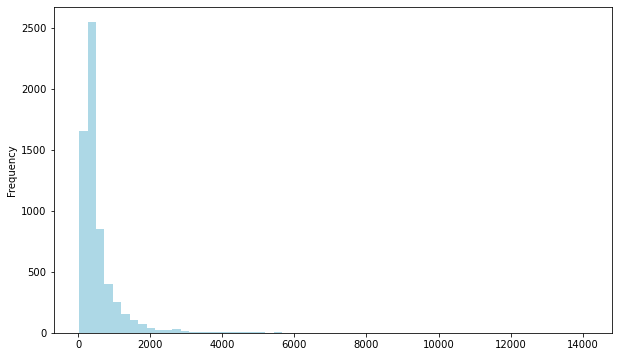

In [82]:
df['Price'].plot.hist(bins=60, figsize=(10,6), color='lightblue');

Well Outlier EveryWhere ...

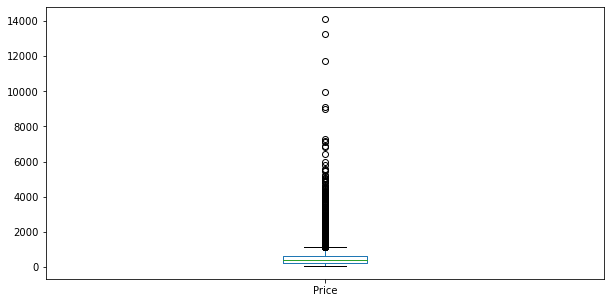

In [45]:
df['Price'].dropna().plot.box(figsize=(10,5));

Most of the value are between +10 to 8000

In [46]:
df['Price'].describe()

count     6237.000000
mean       560.707516
std        690.110657
min         25.000000
25%        249.180000
50%        373.000000
75%        599.000000
max      14100.000000
Name: Price, dtype: float64

In [47]:
# let inspect
df[df['Price'] > 10000]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
886,Modern Labor Economics: Theory and Public Poli...,Ronald G. Ehrenberg,"Hardcover,– Import, 27 Oct 1999",4.0,1.0,Comprehensively surveying the field of labor e...,Labor & Industrial Relations,Politics,13244.67
2455,The Complete Asterix Box Set (36 Titles),Rene Goscinny,"Product Bundle,– 26 Aug 2016",4.9,22.0,"Composed of thirty six, four-colour albums in ...",Comics & Graphic Novels (Books),Comics & Mangas,14100.00
2607,Fifty Cars that Changed the World: Design Muse...,Design Museum Enterprise Limited,"Hardcover,– 6 Oct 2009",4.0,1.0,Everything around us is designed and the word ...,"Arts History, Theory & Criticism (Books)","Arts, Film & Photography",11715.12


I'll Drop all these entries

In [83]:
df = df[df['Price'] <= 10000]

df.shape

(6234, 9)

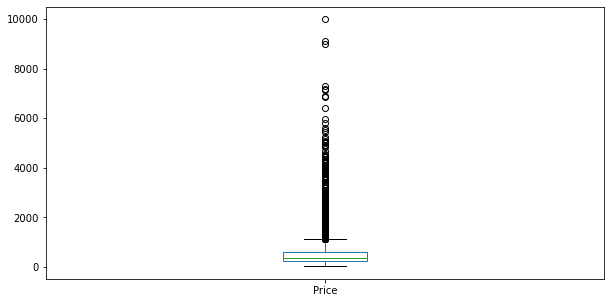

In [84]:
df['Price'].dropna().plot.box(figsize=(10,5));

In [91]:
# significant score
df['SignificantScore'] = (df['Reviews'] / df['Ratings']) 

In [92]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,SignificantScore
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,0.500000
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,0.278571
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00,0.800000
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13.0,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,0.315385
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,5.000000


In [52]:
df['Genre'].nunique()

345

In [53]:
df['BookCategory'].nunique()

11

In [93]:
# created aggregated features as per Genre and BookCategory

df['mean_Genre_Ratings'] = df.groupby('Genre')['Ratings'].transform('mean')
df['std_Genre_Ratings'] = df.groupby('Genre')['Ratings'].transform('std')
df['median_Genre_Ratings'] = df.groupby('Genre')['Ratings'].transform('median')
df['var_Genre_Ratings'] = df.groupby('Genre')['Ratings'].transform('var')

df['mean_Genre_Reviews'] = df.groupby('Genre')['Reviews'].transform('mean')
df['std_Genre_Reviews'] = df.groupby('Genre')['Reviews'].transform('std')
df['median_Genre_Reviews'] = df.groupby('Genre')['Reviews'].transform('median')
df['var_Genre_Reviews'] = df.groupby('Genre')['Reviews'].transform('var')

df['mean_BookCategory_Ratings'] = df.groupby('BookCategory')['Ratings'].transform('mean')
df['std_BookCategory_Ratings'] = df.groupby('BookCategory')['Ratings'].transform('std')
df['median_BookCategory_Ratings'] = df.groupby('BookCategory')['Ratings'].transform('median')
df['var_BookCategory_Ratings'] = df.groupby('BookCategory')['Ratings'].transform('var')

df['mean_BookCategory_Reviews'] = df.groupby('BookCategory')['Reviews'].transform('mean')
df['std_BookCategorye_Reviews'] = df.groupby('BookCategory')['Reviews'].transform('std')
df['median_BookCategory_Reviews'] = df.groupby('BookCategory')['Reviews'].transform('median')
df['var_BookCategory_Reviews'] = df.groupby('BookCategory')['Reviews'].transform('var')

In [55]:
df['Edition'].nunique()

3367

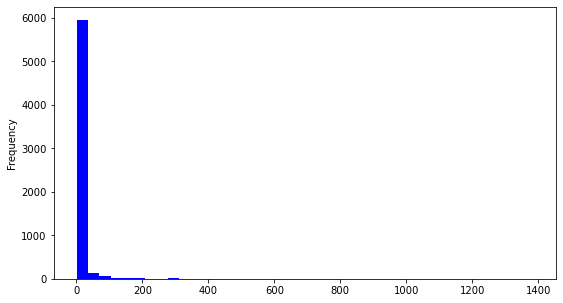

In [64]:
df['SignificantScore'].plot.hist(figsize=(9,5), color='b', bins=40);

In [94]:
df['SignificantScore'].describe()

count    7797.000000
mean        1.333282
std         1.570984
min         0.000722
25%         0.194737
50%         0.633333
75%         1.750000
max         5.000000
Name: SignificantScore, dtype: float64

NOrmalization is what i did to bring some sense to the data

<!--  drop some columns -->

In [67]:
df.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price', 'SignificantScore', 'mean_Genre_Ratings',
       'std_Genre_Ratings', 'median_Genre_Ratings', 'var_Genre_Ratings',
       'mean_Genre_Reviews', 'std_Genre_Reviews', 'median_Genre_Reviews',
       'var_Genre_Reviews', 'mean_BookCategory_Ratings',
       'std_BookCategory_Ratings', 'median_BookCategory_Ratings',
       'var_BookCategory_Ratings', 'mean_BookCategory_Reviews',
       'std_BookCategorye_Reviews', 'median_BookCategory_Reviews',
       'var_BookCategory_Reviews'],
      dtype='object')

In [95]:
# drop some columns
cols_2_drop = ['Title', 'Edition', 'Author', 'Synopsis', 'Genre', 'BookCategory']

df = df.drop(columns=cols_2_drop, axis=1)
df.shape

(7797, 20)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7797 entries, 0 to 1559
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Reviews                      7797 non-null   float64
 1   Ratings                      7797 non-null   float64
 2   Price                        6237 non-null   float64
 3   SignificantScore             7797 non-null   float64
 4   mean_Genre_Ratings           7797 non-null   float64
 5   std_Genre_Ratings            7710 non-null   float64
 6   median_Genre_Ratings         7797 non-null   float64
 7   var_Genre_Ratings            7710 non-null   float64
 8   mean_Genre_Reviews           7797 non-null   float64
 9   std_Genre_Reviews            7710 non-null   float64
 10  median_Genre_Reviews         7797 non-null   float64
 11  var_Genre_Reviews            7710 non-null   float64
 12  mean_BookCategory_Ratings    7797 non-null   float64
 13  std_BookCategory_R

In [70]:
df.fillna(0, inplace=True)

### Now SPark DataFrame

In [97]:
train = df[df['Price'].isna()== False]
test = df[df['Price'].isna()== True]

print(train.shape, test.shape)

(6237, 20) (1560, 20)


In [98]:
test.drop('Price', axis=1, inplace=True)

c:\users\abuton\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

c:\users\abuton\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [100]:
spark_train = spark.createDataFrame(train)
spark_test = spark.createDataFrame(test)

In [101]:
spark_train.show(7)

+-------+-------+------+--------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------------+------------------------+---------------------------+------------------------+-------------------------+-------------------------+---------------------------+------------------------+
|Reviews|Ratings| Price|    SignificantScore|mean_Genre_Ratings| std_Genre_Ratings|median_Genre_Ratings| var_Genre_Ratings|mean_Genre_Reviews| std_Genre_Reviews|median_Genre_Reviews|  var_Genre_Reviews|mean_BookCategory_Ratings|std_BookCategory_Ratings|median_BookCategory_Ratings|var_BookCategory_Ratings|mean_BookCategory_Reviews|std_BookCategorye_Reviews|median_BookCategory_Reviews|var_BookCategory_Reviews|
+-------+-------+------+--------------------+------------------+------------------+--------------------+------------------+------------------+------------------+---------------

In [102]:
exp_book = spark_train.filter("price > 8000")
exp_book.show()

+-------+-------+--------+-------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------------+------------------------+---------------------------+------------------------+-------------------------+-------------------------+---------------------------+------------------------+
|Reviews|Ratings|   Price|   SignificantScore|mean_Genre_Ratings| std_Genre_Ratings|median_Genre_Ratings| var_Genre_Ratings|mean_Genre_Reviews| std_Genre_Reviews|median_Genre_Reviews|  var_Genre_Reviews|mean_BookCategory_Ratings|std_BookCategory_Ratings|median_BookCategory_Ratings|var_BookCategory_Ratings|mean_BookCategory_Reviews|std_BookCategorye_Reviews|median_BookCategory_Reviews|var_BookCategory_Reviews|
+-------+-------+--------+-------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------

### Machine Learning Pipeline with Spark :joy:

In [107]:
spark_train.withColumn('Review', spark_train.Reviews.cast('integer'))

DataFrame[Reviews: double, Ratings: double, Price: double, SignificantScore: double, mean_Genre_Ratings: double, std_Genre_Ratings: double, median_Genre_Ratings: double, var_Genre_Ratings: double, mean_Genre_Reviews: double, std_Genre_Reviews: double, median_Genre_Reviews: double, var_Genre_Reviews: double, mean_BookCategory_Ratings: double, std_BookCategory_Ratings: double, median_BookCategory_Ratings: double, var_BookCategory_Ratings: double, mean_BookCategory_Reviews: double, std_BookCategorye_Reviews: double, median_BookCategory_Reviews: double, var_BookCategory_Reviews: double, Review: int]

In [109]:
spark_train.drop('Review')

DataFrame[Reviews: double, Ratings: double, Price: double, SignificantScore: double, mean_Genre_Ratings: double, std_Genre_Ratings: double, median_Genre_Ratings: double, var_Genre_Ratings: double, mean_Genre_Reviews: double, std_Genre_Reviews: double, median_Genre_Reviews: double, var_Genre_Reviews: double, mean_BookCategory_Ratings: double, std_BookCategory_Ratings: double, median_BookCategory_Ratings: double, var_BookCategory_Ratings: double, mean_BookCategory_Reviews: double, std_BookCategorye_Reviews: double, median_BookCategory_Reviews: double, var_BookCategory_Reviews: double]

In [110]:
spark_train = spark_train.withColumn('Reviews', spark_train.Reviews.cast('integer'))
spark_test = spark_test.withColumn('Reviews', spark_test.Reviews.cast('integer'))

In [111]:
train.columns

Index(['Reviews', 'Ratings', 'Price', 'SignificantScore', 'mean_Genre_Ratings',
       'std_Genre_Ratings', 'median_Genre_Ratings', 'var_Genre_Ratings',
       'mean_Genre_Reviews', 'std_Genre_Reviews', 'median_Genre_Reviews',
       'var_Genre_Reviews', 'mean_BookCategory_Ratings',
       'std_BookCategory_Ratings', 'median_BookCategory_Ratings',
       'var_BookCategory_Ratings', 'mean_BookCategory_Reviews',
       'std_BookCategorye_Reviews', 'median_BookCategory_Reviews',
       'var_BookCategory_Reviews'],
      dtype='object')

In [112]:
# Assemble a Vector 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

# make a vector assembler
vec_assembler = VectorAssembler(inputCols=['Reviews', 'Ratings', 'SignificantScore', 'mean_Genre_Ratings',
       'std_Genre_Ratings', 'median_Genre_Ratings', 'var_Genre_Ratings',
       'mean_Genre_Reviews', 'std_Genre_Reviews', 'median_Genre_Reviews',
       'var_Genre_Reviews', 'mean_BookCategory_Ratings',
       'std_BookCategory_Ratings', 'median_BookCategory_Ratings',
       'var_BookCategory_Ratings', 'mean_BookCategory_Reviews',
       'std_BookCategorye_Reviews', 'median_BookCategory_Reviews',
       'var_BookCategory_Reviews'],
                                outputCol='features')

In [113]:
normalizer_lr = Normalizer(inputCol='features', outputCol='features_norm')

In [114]:
def regression_metrics(prediction):
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(prediction)
    print("RMSE on test data = %g" % rmse)

In [115]:
df_train, df_test = spark_train.randomSplit([0.8, 0.2])

In [117]:
df_train.count()

4979

In [119]:
df_test.count(), spark_test.count()

(1258, 1560)

In [120]:
#LR1 without d normalized data

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="Price", featuresCol='features', maxIter=100, regParam=0.0, elasticNetParam=0.0)
pipeline = Pipeline(stages=[vec_assembler, normalizer_lr, lr])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)
regression_metrics(prediction)

RMSE on test data = 495.796


In [121]:
#LR1 with d normalized data

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="Price", featuresCol='features_norm', maxIter=100, regParam=0.0, elasticNetParam=0.0)
pipeline = Pipeline(stages=[vec_assembler, normalizer_lr, lr])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)
regression_metrics(prediction)

RMSE on test data = 496.318


In [129]:
import pyspark.sql.functions as F
print(F.col('prediciton').values)

Column<b'prediciton[values]'>


In [130]:
pred = prediction.select('prediction')
pred

DataFrame[prediction: double]

In [135]:
#GBT1

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol="Price", maxIter=40)
pipeline = Pipeline(stages=[vec_assembler, normalizer_lr, gbt])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)
regression_metrics(prediction)

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:49507)

In [136]:
def classification_metrics(prediction):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    mcEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("HOURLYWindDirectionBucketized")
    accuracy = mcEval.evaluate(prediction)
    print("Accuracy on test data = %g" % accuracy)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py4j\java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49507)
Traceback (most recent call last):
  File "C:\Users\ABUTON\Desktop\spark\spark-2.4.4-bin-hadoop2.7\python\lib\py4j-0.10.7-src.zip\py